## Text Classification Prediction Explanations

In this notebook, we'll see some methods of explaining the predictions of a text classification model.

In [1]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter 
from scipy.spatial.distance import pdist


In [2]:
# from gensim.models import Word2Vec 
# import gensim

In [3]:
# from transformers import GensimWord2VecVectorizer

In [4]:
from transformers import AutoTokenizer, DistilBertModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, DistilBertConfig, DistilBertTokenizer, DistilBertTokenizerFast, DistilBertPreTrainedModel, DistilBertForTokenClassification, DistilBertForSequenceClassification
# import torch
from datasets import Dataset
from accelerate import Accelerator

In [5]:
from bs4 import BeautifulSoup
import re
from sklearn import preprocessing

In [6]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
        classification_report, confusion_matrix, r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
) 

from sklearn.inspection import PartialDependenceDisplay, permutation_importance, partial_dependence

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from xgboost import XGBClassifier, XGBRegressor, plot_importance
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [9]:
# from category_encoders import TargetEncoder 
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 

# from feature_engine.imputation import CategoricalImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# from xgbimputer import XGBImputer

import tqdm as notebook_tqdm
from tqdm import tqdm

In [10]:
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings

# warnings.filterwarnings(action='ignore')

In [ ]:
HospitalDischargeNotes = pd.read_csv("../data/ReadmissionEnsuesWithin30Days_Xtest_Ypred_df_HospitalDischargeNotesCSV_exported_GatorTron_3iter.csv")

In [ ]:
# HospitalDischargeNotes = HospitalDischargeNotes.head(1000)

In [ ]:
# HospitalDischargeNotes.to_csv('../data/HospitalDischargeNotes_1000.csv', index=False)

In [ ]:
class TextCleaner():
    def __init__(self):
        pass
    
    def clean_text(self, text):
        text = text.lower() # lowercase everything
        text = text.encode('ascii', 'ignore').decode()  # remove unicode characters
        text = re.sub(r'https*\S+', ' ', text) # remove links
        text = re.sub(r'http*\S+', ' ', text)
        text = re.sub(r'<.*?_:>', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        # cleaning up text
        text = re.sub(r'\'\w+', '', text) 
        text = re.sub(r'\w*\d+\w*', '', text)
        text = re.sub(r'\s{2,}', ' ', text)
        text = re.sub(r'\s[^\w\s]\s', '', text)
        return text

cleaner = TextCleaner()
HospitalDischargeNotes['cleaned_text'] = HospitalDischargeNotes['text'].apply(cleaner.clean_text)
HospitalDischargeNotes

Consumer complaint narrative  Issue
0      a couple years ago i had a dispute with this s...      3
1      on xxxxxxxx i received my credit report and fo...      0
2      on xxxxxxxxxxxx i wrote trans union a letter a...      3
3      i was looking through my credit report today x...      3
4      xxxx xxxx acct xxxx n accordance with the fair...      3
...                                                  ...    ...
70682  im currently working on identity theft gov and...      0
70683  i am giving you one warning because i will sue...      3
70684  in the beginning of xxxxxxxx i was presented w...      3
70685  i am a recent graduate from xxxx xxxx in xxxx ...      2
70686  xxxxxxxxxxxx xxxx xxxx xxxx received my first ...      0

[70687 rows x 2 columns]

y_raw = HospitalDischargeNotes['ReadmissionEnsuesWithin30Days']

In [ ]:
le = preprocessing.LabelEncoder()
HospitalDischargeNotes['ReadmissionEnsuesWithin30Days'] = le.fit_transform(HospitalDischargeNotes['ReadmissionEnsuesWithin30Days'].tolist())

In [ ]:
y_encoded = HospitalDischargeNotes['ReadmissionEnsuesWithin30Days']
y_encoded

0        3
1        0
2        3
3        3
4        3
        ..
70682    0
70683    3
70684    3
70685    2
70686    0
Name: Issue, Length: 70687, dtype: int64

In [ ]:
X = HospitalDischargeNotes[['cleaned_text']]
X # = X['cleaned_text'].fillna("").apply(str.split)


Consumer complaint narrative
0      a couple years ago i had a dispute with this s...
1      on xxxxxxxx i received my credit report and fo...
2      on xxxxxxxxxxxx i wrote trans union a letter a...
3      i was looking through my credit report today x...
4      xxxx xxxx acct xxxx n accordance with the fair...
...                                                  ...
70682  im currently working on identity theft gov and...
70683  i am giving you one warning because i will sue...
70684  in the beginning of xxxxxxxx i was presented w...
70685  i am a recent graduate from xxxx xxxx in xxxx ...
70686  xxxxxxxxxxxx xxxx xxxx xxxx received my first ...

[70687 rows x 1 columns]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 321, shuffle=True, stratify = y_encoded)



X_train_tokens = X_train['cleaned_text'].fillna("").apply(str.split)

X_test_tokens = X_test['cleaned_text'].fillna("").apply(str.split)

# tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer(ngram_range=(1,3), stop_words='english') #, min_df = 10)

X_train_vec = tfidf.fit_transform(X_train_tokens.apply(lambda x: ' '.join(x)))
X_test_vec = tfidf.transform(X_test_tokens.apply(lambda x: ' '.join(x)))

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)

y_test_enc = le.transform(y_test)

xgb_model = xgb.XGBClassifier( enable_categorical=True, 
                              objective='multi:softmax', 
                              num_class=len(le.classes_), 
                              n_estimators=1000, 
                              use_label_encoder=True, 
                              eval_metric='mlogloss',
                              random_state = 535)


xgb_model.fit(X_train_vec, y_train_enc)

y_pred_enc = xgb_model.predict(X_test_vec)

y_pred = le.inverse_transform(y_pred_enc)

In [ ]:
ct0 = ColumnTransformer(
        [('tokenizer', TfidfVectorizer(stop_words='english'), 'cleaned_text')
         ],
        remainder='passthrough')

xgbc_pipe = Pipeline(
    steps=[
        ('preprocessor0', ct0),
        ('xgbc', XGBClassifier( enable_categorical=True, 
                              objective='multi:softmax', 
                              num_class=len(le.classes_), 
                              n_estimators=10000, 
                              use_label_encoder=True, 
                              eval_metric='mlogloss',
                              random_state = 535)
        )
    ]
).fit(X_train, y_train) 

/Users/bentonwang/Library/Python/3.13/lib/python/site-packages/xgboost/training.py:183: UserWarning: [03:42:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [20]:
y_pred = xgbc_pipe.predict(X_test)

In [21]:
X_test_SHAP = X_test



X_train_tokens = X_train['cleaned_text'].fillna("").apply(str.split)

X_test_tokens = X_test['cleaned_text'].fillna("").apply(str.split)

tfidf = TfidfVectorizer()

X_train_vec = tfidf.fit_transform(X_train_tokens.apply(lambda x: ' '.join(x)))
X_test_vec = tfidf.transform(X_test_tokens.apply(lambda x: ' '.join(x)))

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)

y_test_enc = le.transform(y_test)

xgb_model = xgb.XGBClassifier( enable_categorical=True, 
                              objective='multi:softmax', 
                              num_class=len(le.classes_), 
                              n_estimators=1000, 
                              use_label_encoder=True, 
                              eval_metric='mlogloss',
                              random_state = 535)


xgb_model.fit(X_train_vec, y_train_enc)

y_pred_enc = xgb_model.predict(X_test_vec)

y_pred = le.inverse_transform(y_pred_enc)

# xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100)

X_train_tokens = X_train['cleaned_text'].fillna("").apply(str.split)

X_test_tokens = X_test['cleaned_text'].fillna("").apply(str.split)

w2v_model = gensim.models.Word2Vec(sentences=X_train_tokens, vector_size=1000, window=10, min_count=1, workers=4)

def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

X_train_vec = np.vstack(X_train_tokens.apply(lambda x: document_vector(x, w2v_model)))

X_test_vec = np.vstack(X_test_tokens.apply(lambda x: document_vector(x, w2v_model)))

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)

y_test_enc = le.transform(y_test)

xgb_model = xgb.XGBClassifier( enable_categorical=True, 
                              objective='multi:softmax', 
                              num_class=len(le.classes_), 
                              n_estimators=10000, 
                              use_label_encoder=True, 
                              eval_metric='mlogloss',
                              random_state = 535)


xgb_model.fit(X_train_vec, y_train_enc)

y_pred_enc = xgb_model.predict(X_test_vec)

y_pred = le.inverse_transform(y_pred_enc)

In [22]:
accuracy_score(y_test, y_pred)

0.8781298627811571

In [23]:
confusion_matrix(y_test, y_pred)

array([[2095,  126,   21,  671,   14],
       [ 166,  639,    5,   36,    4],
       [  15,    9,  431,   35,    4],
       [ 494,   22,   15, 8611,   30],
       [   8,    8,    4,   36,  639]])

In [ ]:
print(classification_report(y_true, y_pred, zero_division = 0, target_names=['No Recorded Hospital Readmission Within 30 Days', 'Readmitted to Hospital Within 30 Days']))

              precision    recall  f1-score   support

           0       0.75      0.72      0.73      2927
           1       0.79      0.75      0.77       850
           2       0.91      0.87      0.89       494
           3       0.92      0.94      0.93      9172
           4       0.92      0.92      0.92       695

    accuracy                           0.88     14138
   macro avg       0.86      0.84      0.85     14138
weighted avg       0.88      0.88      0.88     14138



In [ ]:
print(classification_report(
    y_true=tokenized_test['labels'],
    y_pred=np.argmax(trainer.predict(tokenized_test).predictions, axis=1),
    target_names=le.classes_
))

# Top Features' Importance Quantification


In [25]:
selection = SelectFromModel(xgbc_pipe[-1], threshold=0.0001, prefit=True)

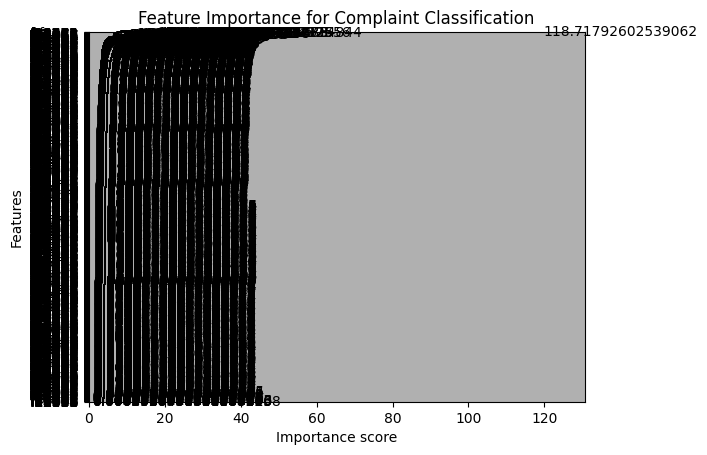

In [26]:
plot_importance_object = plot_importance(xgbc_pipe[-1], importance_type='gain')
plt.title('Feature Importance for Complaint Classification')
plt.show()

In [27]:
X_feature_names = xgbc_pipe[:-1].get_feature_names_out()
X_feature_names

array(['tokenizer__00', 'tokenizer__000', 'tokenizer__0000', ...,
       'tokenizer__zooming', 'tokenizer__zwicker', 'tokenizer__zxxxx'],
      shape=(45001,), dtype=object)

In [28]:
importances = xgbc_pipe[-1].feature_importances_

In [29]:
importance_df = pd.DataFrame({'word': X_feature_names, 'importance': importances})   

In [30]:
importance_df = importance_df.sort_values(by='importance', ascending=False)

importance_df = importance_df[importance_df['importance'] > 0]

importance_df.head(30)

word  importance
26732              tokenizer__mute    0.045114
26212      tokenizer__modification    0.011645
9275                tokenizer__cfr    0.010500
34633          tokenizer__revision    0.008767
32531          tokenizer__receives    0.008675
12965       tokenizer__declaration    0.008248
30719     tokenizer__possibilities    0.008151
35331              tokenizer__save    0.006784
15791           tokenizer__enacted    0.006549
31715       tokenizer__provisional    0.006452
33073        tokenizer__regulatory    0.006330
10110          tokenizer__coinbase    0.006148
17456         tokenizer__feedbacks    0.005497
15484       tokenizer__efficiently    0.005474
10372       tokenizer__comfortable    0.004858
42398             tokenizer__voice    0.004506
7859               tokenizer__bond    0.004376
28036           tokenizer__obscene    0.004257
35377           tokenizer__scammed    0.003952
26181               tokenizer__mod    0.003696
38489          tokenizer__suspects    0.003689
16743          tokenizer__expedite    0.003677
39702           tokenizer__tickets    0.003649
44970             tokenizer__zelle    0.003592
20988  tokenizer__identitytheftgov    0.003535
9797             tokenizer__clause    0.003338
5362            tokenizer__anguish    0.003321
43054           tokenizer__willful    0.003290
31253            tokenizer__prison    0.003069
29913           tokenizer__perform    0.002864

# SHAP

xgbc_pipe_XGBClassifier = xgbc_pipe[0]
xgbc_pipe_XGBClassifier

X_test_transformed_SHAP = xgbc_pipe_XGBClassifier.transform(X_test_SHAP)
X_test_transformed_SHAP  

In [31]:
explainer = shap.TreeExplainer(xgbc_pipe[1])
explanation = explainer(xgbc_pipe[0].transform(X_test_SHAP))

In [32]:
explainer.shap_values(xgbc_pipe[0].transform(X_test_SHAP))

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.00242922,  0.00362985, -0.00028015, -0.00546977,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.00077708,  0.00345579, -0.00058652, -0.01514339,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        , 

In [33]:
explanation[:,:,2]

.values =
array([[ 0.        , -0.00028015,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.00058652,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.00028015,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.00028015,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.00028015,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.00028015,  0.        , ...,  0.        ,
         0.        ,  0.        ]], shape=(14138, 45001), dtype=float32)

.base_values =
array([-1.1708364, -1.1708364, -1.1708364, ..., -1.1708364, -1.1708364,
       -1.1708364], shape=(14138,), dtype=float32)

.data =
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 703589 stored elements and shape (14138, 45001)>

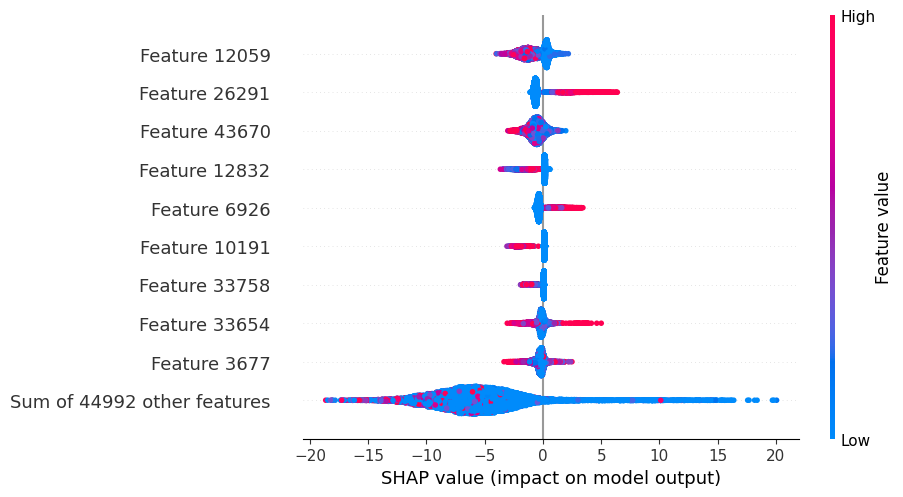

In [34]:
shap.plots.beeswarm(explanation[:,:,2])

In [43]:
xgbc_pipe[:-1].get_feature_names_out()[[12059, 26291, 43670, 12832, 6926, 10191, 33758, 33654, 3677]].tolist()

['tokenizer__credit',
 'tokenizer__money',
 'tokenizer__xxxx',
 'tokenizer__debt',
 'tokenizer__bank',
 'tokenizer__collection',
 'tokenizer__reporting',
 'tokenizer__report',
 'tokenizer__account']

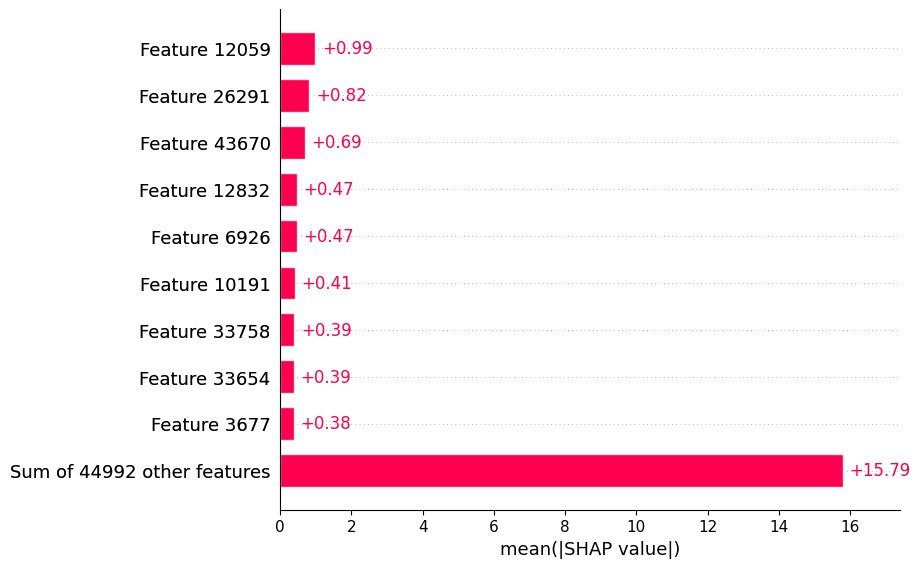

In [36]:
shap.plots.bar(explanation[:,:,2])

In [ ]:
pd.DataFrame({'cleaned_text': X_test_SHAP['cleaned_text'], 'SHAP_value':explanation[:,:,2].values[:,0]}).groupby('cleaned_text')['SHAP_value'].mean().sort_values(ascending = False)#[lambda x: x > 0]

Consumer complaint narrative
014 xxxx xxxx xxxx letter on unfair or deceptive credit practices the ftc act and the doddfrank act continue to prohibit unfair or deceptive acts or xxxx may determine a statutory violation exists depending on the facts and ftc violations                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [38]:
explanation[:,:,2][0].values[0]

np.float32(0.0)

In [39]:
import seaborn as sns

In [ ]:
Narrative_Exploration = pd.DataFrame({'cleaned_text': X_test['cleaned_text'], 'SHAP_value':explanation[:,:,2].values[:,4]})

In [ ]:
pd.DataFrame({'cleaned_text': X_test_SHAP['cleaned_text'], 'SHAP_value':explanation[:,:,2].values[:,4]}).plot(kind = 'scatter', x='cleaned_text', y='SHAP_value')

<Axes: xlabel='Consumer complaint narrative', ylabel='SHAP_value'>

In [ ]:
sns.regplot(data = Narrative_Exploration, x='cleaned_text', y='SHAP_value')

DTypePromotionError: The DType <class 'numpy.dtypes._PyFloatDType'> could not be promoted by <class 'numpy.dtypes.StrDType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes._PyFloatDType'>)

IndexError: index 0 is out of bounds for axis 0 with size 0

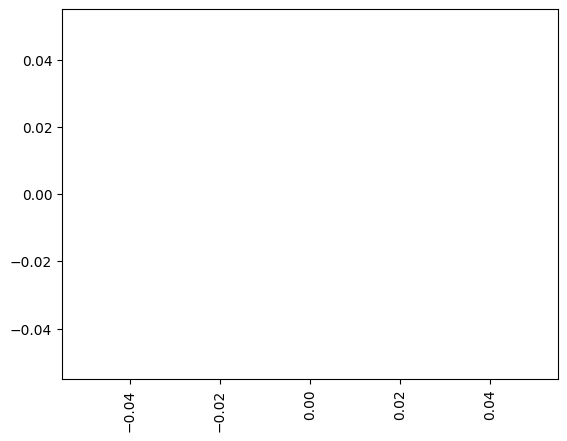

In [ ]:
pd.DataFrame({'cleaned_text': X_test_SHAP['cleaned_text'], 'SHAP_value':explanation[:,:,1].values[:,0]}).groupby('cleaned_text')['SHAP_value'].mean().sort_values(ascending = False)[lambda x: x > 0].head(10).plot(kind = 'bar')

In [ ]:
pd.DataFrame({'LampStatus': X_test['LampStatus'], 'SHAP_value':explanation[:,:,1].values[:,2]}).groupby('LampStatus')['SHAP_value'].mean().sort_values(ascending = False) #.plot(kind = 'bar') #[lambda x: x > 0]

In [ ]:
pd.DataFrame({'LampStatus': X_test['LampStatus'], 'SHAP_value':explanation[:,:,1].values[:,2]}).groupby('LampStatus')['SHAP_value'].mean().sort_values(ascending = False).plot(kind = 'bar')

In [ ]:
pd.DataFrame({'ecuSource': X_test['ecuSource'], 'SHAP_value':explanation[:,:,1].values[:,1]}).groupby('ecuSource')['SHAP_value'].mean().sort_values(ascending = False).plot(kind = 'bar')

In [ ]:
xgbc_pipe[:-1].get_feature_names_out()[[0, 2, 16, 1, 8, 17, 3, 22, 7]].tolist()

In [ ]:
xgbc_pipe[:-1].get_feature_names_out()

In [ ]:
X_selected = selection.transform(X_train_vec) # xgb_model.get_feature_names_out()
X_selected
                                    # X_train_tokens # X_train_vec

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
feature_importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': xgb_model.get_feature_names_out(), 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_30_features = feature_importance_df.head(30)

print(top_30_features)

AttributeError: 'XGBClassifier' object has no attribute 'get_feature_names_out'

In [ ]:
print("Top 30 features:", top_30_features['Feature'].tolist())